In [2]:
!pip install stable-baselines3[extra]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00


In [6]:
!pip install 'shimmy>=2.0'

Episode 1/2000, Reward: 9.0
Episode 2/2000, Reward: 10.0
Episode 3/2000, Reward: 12.0
Episode 4/2000, Reward: 11.0
Episode 5/2000, Reward: 9.0
Episode 6/2000, Reward: 11.0
Episode 7/2000, Reward: 9.0
Episode 8/2000, Reward: 9.0
Episode 9/2000, Reward: 9.0
Episode 10/2000, Reward: 10.0
Episode 11/2000, Reward: 19.0
Episode 12/2000, Reward: 9.0
Episode 13/2000, Reward: 8.0
Episode 14/2000, Reward: 9.0
Episode 15/2000, Reward: 9.0
Episode 16/2000, Reward: 10.0
Episode 17/2000, Reward: 9.0
Episode 18/2000, Reward: 9.0
Episode 19/2000, Reward: 9.0
Episode 20/2000, Reward: 8.0
Episode 21/2000, Reward: 9.0
Episode 22/2000, Reward: 9.0
Episode 23/2000, Reward: 9.0
Episode 24/2000, Reward: 9.0
Episode 25/2000, Reward: 9.0
Episode 26/2000, Reward: 9.0
Episode 27/2000, Reward: 9.0
Episode 28/2000, Reward: 9.0
Episode 29/2000, Reward: 9.0
Episode 30/2000, Reward: 10.0
Episode 31/2000, Reward: 10.0
Episode 32/2000, Reward: 11.0
Episode 33/2000, Reward: 10.0
Episode 34/2000, Reward: 10.0
Episode 35/

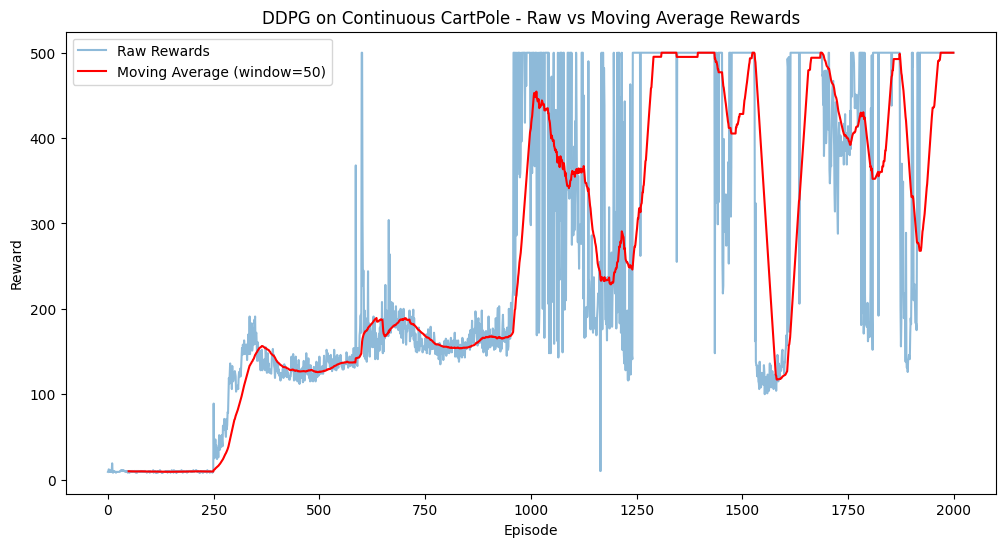

In [11]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Custom wrapper for continuous CartPole
class ContinuousCartPoleWrapper(gym.Env):
    def __init__(self, env):
        self.env = env
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = self.env.observation_space

    def step(self, action):
        discrete_action = 0 if action < 0.5 else 1
        obs, reward, done, info = self.env.step(discrete_action)
        return obs, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()


# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid(),  # Logistic output
        )

    def forward(self, state):
        return self.net(state)


# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))


# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1),
        )

    def size(self):
        return len(self.buffer)


# Train the DDPG agent
def train_ddpg(env, actor, critic, target_actor, target_critic, buffer, actor_optimizer, critic_optimizer, n_episodes=2000, batch_size=64):
    gamma = 0.99
    tau = 0.005  # Soft update parameter
    rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0

        while True:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action = actor(state_tensor).detach().numpy()[0]
            next_state, reward, done, _ = env.step(action)
            buffer.add((state, action, reward, next_state, done))

            if buffer.size() > batch_size:
                # Sample from buffer
                states, actions, rewards_batch, next_states, dones = buffer.sample(batch_size)

                # Update Critic
                target_actions = target_actor(next_states)
                target_q_values = rewards_batch + gamma * (1 - dones) * target_critic(next_states, target_actions).detach()
                critic_loss = nn.MSELoss()(critic(states, actions), target_q_values)
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # Update Actor
                actor_loss = -critic(states, actor(states)).mean()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Soft update of target networks
                for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            state = next_state
            episode_reward += reward
            if done:
                break

        rewards.append(episode_reward)
        print(f"Episode {episode + 1}/{n_episodes}, Reward: {episode_reward}")

    return rewards


# Function to calculate moving average
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


# Main
env = ContinuousCartPoleWrapper(gym.make("CartPole-v1"))

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)
target_actor = Actor(state_dim, action_dim)
target_critic = Critic(state_dim, action_dim)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

buffer = ReplayBuffer(capacity=100000)

# Train the DDPG agent and get rewards
rewards = train_ddpg(env, actor, critic, target_actor, target_critic, buffer, actor_optimizer, critic_optimizer)

# Calculate moving average rewards
window_size = 50
smoothed_rewards = moving_average(rewards, window_size)

# Plot raw rewards and moving average
plt.figure(figsize=(12, 6))
plt.plot(rewards, label="Raw Rewards", alpha=0.5)
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f"Moving Average (window={window_size})", color="red")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG on Continuous CartPole - Raw vs Moving Average Rewards")
plt.legend()
plt.show()

